In [2]:
# import packages

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Set the 'ggplot' style
plt.style.use('ggplot')


SyntaxError: invalid syntax (<ipython-input-2-85880fcfe4c1>, line 2)

In [5]:
# upload data
city_info = pd.read_excel('bycode.xls',  index_col=False)
voting = pd.read_csv('expb_.csv',sep = "\t", index_col=False)

voting.columns = ['town_name', 'town_sym', 'ballot_num', 'bzb', 'tot_votes','tot_invalid','tot_valid']+list(voting.columns[7:])


In [6]:
# CREATE NEW FEATURE: SETTLEMENT TYPE

# Calculate the percentage of missing values in each column
missing_percentage = (city_info.isnull().mean() * 100).round(2)
print("Percentage of missing values per column:")
print(missing_percentage)

# create a new categorial feature: settlement type: Mixed, Kibbutz, Rlg_Kibbutz, Rlg, Moshav, Yishuv, Arab, Bedouin, Jewish
city_info['settlement_type'] = ''

# Create the new feature using boolean indexing
city_info['settlement_type'] = np.where(city_info['דת יישוב'] == 2, 'Arab',"Jewish_Other")
city_info['settlement_type'] = np.where(city_info['דת יישוב'] == 3, 'Bedouin',city_info['settlement_type'])
city_info['settlement_type'] = np.where(city_info['דת יישוב'] == 4, 'Mixed',city_info['settlement_type'])
city_info['settlement_type'] = np.where(city_info['השתייכות ארגונית'].isin([1,15]), 'Kibbutz,Yishuv',city_info['settlement_type'])
city_info['settlement_type'] = np.where(city_info['השתייכות ארגונית'].isin([3,8]), 'Jewish_Religious',city_info['settlement_type'])
city_info['settlement_type'] = np.where(city_info['השתייכות ארגונית'].isin([9,11]), 'Jewish_Religious',city_info['settlement_type'])
city_info['settlement_type'] = np.where(city_info['השתייכות ארגונית'].isin([7,13,19]), 'Kibbutz,Yishuv',city_info['settlement_type'])
city_info['settlement_type'] = np.where(city_info['השתייכות ארגונית'].isin([2,6,10]), 'Jewish_Religious',city_info['settlement_type'])

city_info["town_sym"] = city_info['סמל']
city_info = city_info.drop(columns = ['סמל'])

city_info['יהודים'] = city_info['יהודים']*1000
city_info['ערבים'] = city_info['ערבים']*1000


Percentage of missing values per column:
שם יישוב                  0.00
שם יישוב.1               16.48
סמל                       0.00
תעתיק                    14.02
מחוז                      0.00
נפה                       0.00
אזור טבעי                 8.96
מעמד מונציפאלי            4.79
שיוך מטרופוליני          62.18
דת יישוב                 15.12
סך הכל אוכלוסייה 2013    17.58
יהודים ואחרים            26.27
יהודים                   26.40
ערבים                    90.77
שנת ייסוד                25.72
צורת יישוב שוטפת          0.00
השתייכות ארגונית         43.57
קואורדינטות               1.16
גובה ממוצע               16.48
ועדת תכנון               10.33
מרחב משטרה               10.05
תעתיק פרסומים            15.94
שנת עיבוד                15.94
שדה לקישור               16.48
dtype: float64


In [8]:
# PREPARE VOTING DATA

# prepare dataframes - one for votes per ballot, one to map town symbol to town number
voting_cluster = voting.drop(columns = ['town_name','ballot_num', 'tot_votes','tot_invalid'])
symbol_town = voting[['town_name', 'town_sym']]

# check for nulls in data - there is non
print("Number of nan values per column in voting data:")
print(voting_cluster.isnull().sum())

# remove ballot boxes with zero valid votes
voting_cluster = voting_cluster[voting_cluster['tot_valid'] != 0]

# Normalize each value to be a percentage and not count
cols_to_normalize = voting_cluster.columns[3:]
voting_cluster[cols_to_normalize] = voting_cluster[cols_to_normalize].div(voting_cluster[cols_to_normalize].sum(axis=1), axis=0) * 100

metadata = city_info[['שם יישוב','town_sym','סך הכל אוכלוסייה 2013','settlement_type']]

# merge data and metadata
voting_cluster = pd.merge(metadata,voting_cluster, on='town_sym', how='inner')

Number of nan values per column in voting data:
town_sym     0
bzb          0
tot_valid    0
אמת          0
ג            0
ד            0
הי           0
הפ           0
הק           0
ו            0
ז            0
זה           0
זך           0
טב           0
יק           0
כן           0
מחל          0
מרץ          0
נ            0
ני           0
נץ           0
נק           0
עם           0
פ            0
פה           0
פז           0
פי           0
פך           0
פנ           0
פץ           0
ץ            0
צפ           0
צק           0
ק            0
קנ           0
רק           0
שס           0
dtype: int64


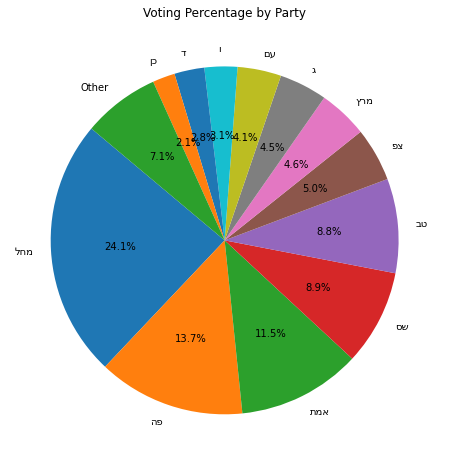

In [9]:
# VISUALIZATION OF VOTING DATA

# make a pie chart of voting percentage of the 12 biggest parties

NUM_PARTIES = 12

# create a mean percentage of votes per party
mean_df = voting_cluster.mean().reset_index()
mean_df = mean_df.iloc[4:]
mean_df.columns = ["Party","Percentage"]
mean_df = mean_df.sort_values(by='Percentage', ascending=False)
mean_df['Party'] = mean_df['Party'].apply(lambda x: x[::-1])

# Keep the top 12 parties, and sum up the rest into 'Other'
top_parties = mean_df.head(NUM_PARTIES)
other_party = pd.DataFrame({'Party': ['Other'], 'Percentage': [mean_df.iloc[NUM_PARTIES:]['Percentage'].sum()]})

# Concatenate top parties and 'Other'
mean_df = pd.concat([top_parties, other_party])

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(mean_df['Percentage'], labels=mean_df['Party'], autopct='%1.1f%%', startangle=140)
plt.title('Voting Percentage by Party')
plt.show()


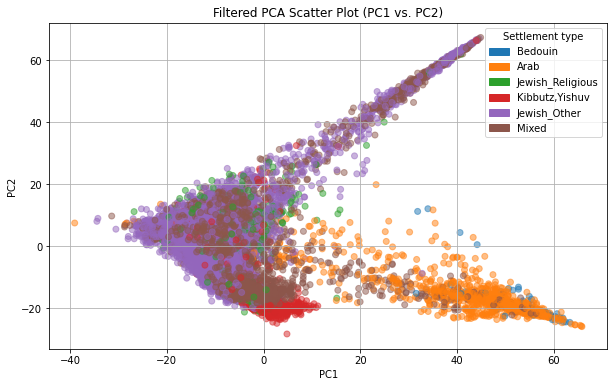

In [10]:
# CLUSTER BALLOT BOXES ACCORDING TO VOTE DISTRIBUTION


from sklearn.decomposition import PCA
import matplotlib.patches

# If needed, remove Jewish and mixed data points to see other clusters more clearly
# voting_cluster = voting_cluster[~(voting_cluster['settlement_type'] == 'Jewish_Other')]
# voting_cluster = voting_cluster[~(voting_cluster['settlement_type'] == 'Mixed')]


# Instantiate the PCA model with the number of components to retain
n_components = 2
pca = PCA(n_components=n_components)

# Extract the values of the column to use for coloring
color_values = voting_cluster['settlement_type']

# Fit and transform data using PCA
pca_result = pca.fit_transform(voting_cluster.drop(columns = ['settlement_type','town_sym','tot_valid','שם יישוב','סך הכל אוכלוסייה 2013','bzb']))

# color datapoints according to settlement_type feature
levels, categories = pd.factorize(color_values)
colors = [plt.cm.tab10(i) for i in levels]
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

# plot PCA
plt.figure(figsize=(10, 6))
sc = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Filtered PCA Scatter Plot (PC1 vs. PC2)')
plt.grid(True)
plt.legend(handles=handles, title='Settlement type')
plt.show()


In [13]:
# LOOK INTO INTERESTING DATA POINTS IN THE PCA

def get_town_names(pc, threshold_low, threshold_high, filter_by_type = None):
    indices_within_threshold = np.where((pca_result[:, pc-1] >= threshold_low) & (pca_result[:, pc-1] <= threshold_high))[0]

    towns = voting_cluster.iloc[indices_within_threshold]
    if filter_by_type:
        towns = towns[voting_cluster['settlement_type'].isin(filter_by_type)]

    value_counts_sorted = towns['שם יישוב'].value_counts()
    print(value_counts_sorted[:10])

# Find town names in the cluster at the top right part of the plot
print("Get town names in the top right cluster:")
get_town_names(pc=2, threshold_low=40, threshold_high=70)

# We get mostly from: Jerusalem, Bnei Brak, Modi'in Ilit, Beitar Ilit, Beit Shemesh etc...
# Which leads to the assumption that this cluster consists of Ultra Orthodox towns and cities

# Find Arab towns within the Jewish cluster
print("Get Arab town names within the Jewish cluster:")
get_town_names(pc=1, threshold_low=-40, threshold_high=-10, filter_by_type=['Arab','Bedouin'])

# We get mostly Druze villages which makes sense


Get town names in the top right cluster:
ירושלים          172
בני ברק          126
מודיעין עילית     34
ביתר עילית        30
בית שמש           28
אשדוד             24
אלעד              18
חיפה               8
רכסים              8
אופקים             5
Name: שם יישוב, dtype: int64
Get Arab town names within the Jewish cluster:
כסרא-סמיע    4
יאנוח-ג'ת    3
חורפיש       3
סאג'ור       2
בוקעאתא      1
מסעדה        1
ע'ג'ר        1
מג'דל שמס    1
Name: שם יישוב, dtype: int64


<ipython-input-13-20208ed89ee0>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  towns = towns[voting_cluster['settlement_type'].isin(filter_by_type)]


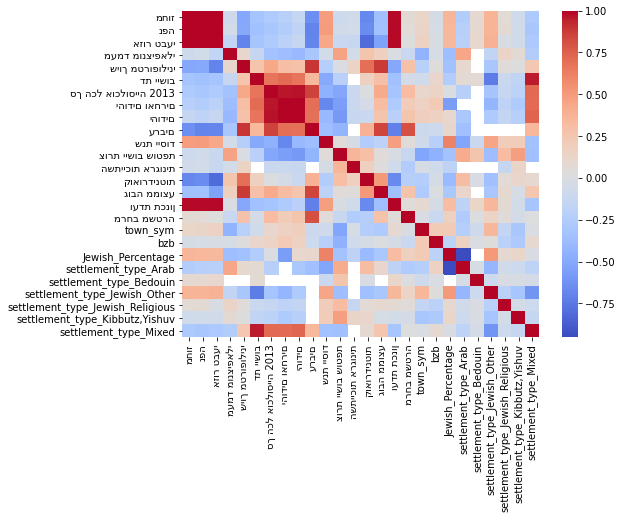

In [14]:
# PREPARE DATA FOR CLASSIFICATION MODEL

# features: towns metadata
# predicted value: the party with the largest number of votes per ballot box

# Create a new column indicating the party with the highest number of votes per ballot box
winning_party = voting.drop(columns = ['town_name','ballot_num','tot_votes','tot_valid','tot_invalid'])
winning_party['winning'] = winning_party.iloc[:, 2:].idxmax(axis=1)
winning_party = winning_party[['town_sym', 'winning','bzb']]

predict_df = pd.merge(city_info,winning_party, on='town_sym', how='inner')

# FEATURE ENGINEERING

# remove redundant columns of Jews and Arabs to create Jewish percentage.
predict_df['יהודים'] = np.fmax(predict_df['סך הכל אוכלוסייה 2013']-predict_df['ערבים'],predict_df['יהודים'])
predict_df['Jewish_Percentage'] = 100*(predict_df['יהודים'] / predict_df['סך הכל אוכלוסייה 2013'])

# sometimes number of Jewish residents is larger than total resident (a problem in the data)
# so clip percentage to be in correct form.
predict_df['Jewish_Percentage'] = np.clip(predict_df['Jewish_Percentage'], 0, 100)

# create a one hot encoding for the settlement type feature
predict_df = pd.get_dummies(predict_df, columns=['settlement_type'])

# change data type from object to numeric of year column
predict_df['שנת ייסוד'] = pd.to_numeric(predict_df['שנת ייסוד'], errors='coerce').astype('Int64')

# The majority of settlements with missing establishment year are arab towns, so adding a year before the establishment
# of the state of Israel is fitting
predict_df['שנת ייסוד'] = predict_df['שנת ייסוד'].fillna(1850)

# remove non numeric features and normalize df to calculate correlation matrix
predict_df_norm = predict_df.drop(columns = ['winning','שם יישוב',"תעתיק",'שם יישוב.1',"תעתיק פרסומים",'שנת עיבוד','שדה לקישור'])
scaler = MinMaxScaler()
predict_df_norm = pd.DataFrame(scaler.fit_transform(predict_df_norm), columns=predict_df_norm.columns)

# Calculate correlation matrix to find redundant features
correlation_matrix = predict_df_norm.corr()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.yticks(rotation=0)
plt.show()

# the following groups of features are highly correlated:
# settlement_type_mixed - דת ישוב
# אזור טבעי, נפה, מחוז, ועדת תכנון
# יהודים, יהודים ואחרים, סך אוכלוסיה

# choose features for model
predict_df = predict_df[['שם יישוב','bzb','ועדת תכנון','מעמד מונציפאלי','שיוך מטרופוליני','דת יישוב','סך הכל אוכלוסייה 2013','שנת ייסוד','צורת יישוב שוטפת','מרחב משטרה','השתייכות ארגונית','Jewish_Percentage','settlement_type_Jewish_Religious','settlement_type_Jewish_Other','settlement_type_Arab','settlement_type_Kibbutz,Yishuv','settlement_type_Bedouin','winning']]

# Calculate the percentage of missing values in each column
missing_percentage = (predict_df.isnull().mean() * 100).round(2)

# for now, avoid using features with high percentage of missing values
predict_df = predict_df.drop(columns = ['שיוך מטרופוליני','השתייכות ארגונית'])

# replace inf with nan, remove all rows with nan values
predict_df.replace([np.inf, -np.inf], np.nan, inplace=True)
predict_df = predict_df.dropna()

# Remove rows with parties of less then 20 town max voters
value_counts = predict_df['winning'].value_counts()
threshold = 20
valid_values = value_counts[value_counts >= threshold].index
predict_df = predict_df[predict_df['winning'].isin(valid_values)]


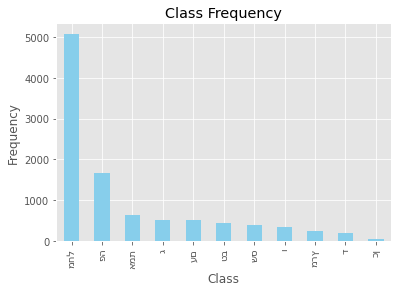

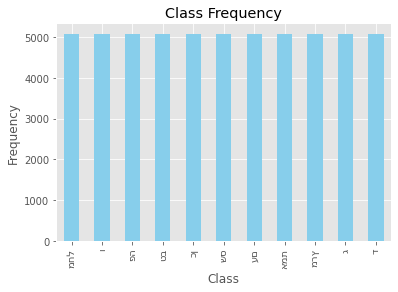

In [9]:
# DEAL WITH DATA IMBALANCE

# Count how many times each class occured in the data
class_counts = predict_df['winning'].value_counts()
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# highly imbalanced data!

# Separate between data and predicted values
X = predict_df.drop(columns = ['winning','שם יישוב'])
y = predict_df['winning']

# Fit and transform the DataFrame to be between [0,1]
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


#OPTION 1: SMOTE - Creating artificial samples for unrepresented classes
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# show new data points distribution
class_counts = y.value_counts()
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


# OPTION 2: class weights
# failed horribly using "balanced" class weights

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
# RANDOM SEARCH TO LOOK FOR BEST PARAMETERS


# Perform CV grid search to look for the best hyperparameters for the model
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Perform a grid search
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the grid search to the data
rf_random.fit(X_train, y_train)

# Get the best hyperparameters
best_params = rf_random.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = rf_random.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
#GRID SEARCH

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [3, 5, 8],
    'n_estimators': [100, 200, 600, 700]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = rf_random.best_params_
print("Best Hyperparameters:", best_params)

In [30]:
# TRAIN AND TEST MODEL

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=20,
                                       min_samples_split=5,
                                       min_samples_leaf=3,
                                       max_features=3,
                                       max_depth=20,
                                       bootstrap=True,
                                       random_state=42,
                                       )
# Train the classifier
rf_classifier.fit(X_train, y_train)


# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance of the model
print(f'Train Accuracy: {accuracy_score(y_train, rf_classifier.predict(X_train)):.2f}')


# Print classification report
print('Train Classification Report:')
print(classification_report(y_train, rf_classifier.predict(X_train)))


# Evaluate the performance of the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')


# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print(feature_importance_df)

Train Accuracy: 0.86
Train Classification Report:
              precision    recall  f1-score   support

         אמת       0.92      0.83      0.87      4083
           ג       0.79      0.88      0.83      4075
           ד       0.91      0.94      0.92      4097
           ו       0.87      0.93      0.90      4089
          טב       0.87      0.84      0.85      4040
          כן       1.00      1.00      1.00      4056
         מחל       0.79      0.69      0.73      4033
         מרץ       0.75      0.95      0.84      4089
          עם       0.95      0.89      0.92      4069
          פה       0.78      0.75      0.77      4062
          שס       0.85      0.73      0.78      4055

    accuracy                           0.86     44748
   macro avg       0.86      0.86      0.86     44748
weighted avg       0.86      0.86      0.86     44748

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

         אמת       0.82      0.76      0.79 

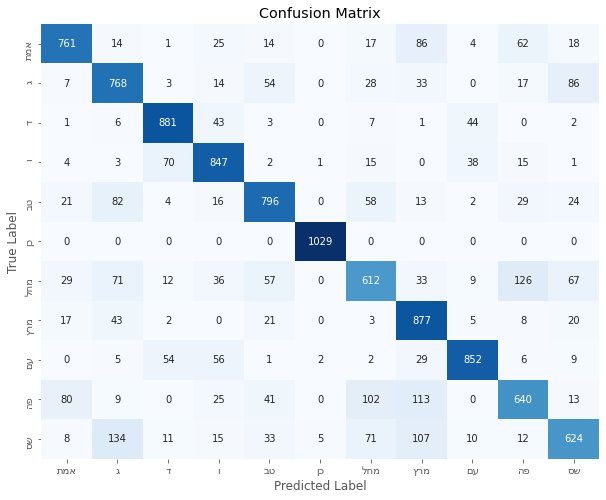

In [31]:

from sklearn.metrics import confusion_matrix, classification_report

# Get unique class labels
class_labels = sorted(predict_df['winning'].unique())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Reverse hebrew script
conf_matrix_df.columns = conf_matrix_df.columns.map(lambda x: x[::-1])
conf_matrix_df.index = conf_matrix_df.index.map(lambda x: x[::-1])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Conclusions:
# Highly unbalanced data
# good performance on arab parties
# poor performance on Ultra Orthodox parties, need to find a feature to better identify UO cities.
# confusion between some of the parties is understandable


In [75]:
from sklearn.ensemble import IsolationForest

X = predict_df.drop(columns = ['winning','שם יישוב'])

# Fit Isolation Forest model
isolation_forest = IsolationForest(contamination=0.005, random_state=42)
predict_df['is_outlier'] = isolation_forest.fit_predict(X)
outliers = predict_df[predict_df['is_outlier']==-1][['שם יישוב','winning']]
print(outliers)


c:\users\user\pycharmprojects\tictactoe_game\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


                    שם יישוב winning
2                    אבו גוש       ד
6                    אבו גוש       ד
7                    אבו גוש       ד
21       אבו קורינאת (יישוב)      עם
40                   אבטליון     אמת
68                  אבני חפץ      טב
69                    אבשלום     מחל
70                     אדורה      טב
75                      אודם      פה
371                אל -עריאן       ד
373                  אל סייד      עם
480                    ארגמן     מחל
789                  אשכולות      טב
1340               בית הערבה     מחל
1971                  בת עין      טב
2045             גבעון החדשה     מחל
2046             גבעון החדשה     מחל
2241                    גלגל      פה
2304                     גפן     מחל
2418                  דמיידה       ד
2422                 דריג'את       ד
2512                    הראל     מרץ
2694                  ח'ואלד      עם
2701                   חד-נס      פה
3900                    יפית     מחל
4673                   כסלון     מחל
5

18
